In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from pylab import *
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

sns.set_style("ticks")
font = {
    "font.family": "Roboto",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 2.5,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.6, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Load Data df

data_name = ['PAI', 'Philly',  'Venus']
trace_dfs = []

data_dir = '../data/'
for idx, data in enumerate(data_name):
	if data == 'Philly':
		trace_dir = data_dir + data
		vc_dict = pd.read_pickle(data_dir + data + '/vc_dict_homo.pkl')
		trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00') 
		trace_df, start_ts = utils.trace_philly_process(trace_dir, trace_range, vc_dict)
	elif data == 'PAI':
		vc_dict = pd.read_pickle(data_dir + 'ali20/vc_dict_homo.pkl')
		trace_dir = data_dir + 'ali20'
		trace_df, _ = utils.trace_ali20_process(trace_dir)
	elif data == 'Venus':
		vc_dict = pd.read_pickle(data_dir + data + '/vc_dict_homo.pkl')
		trace_dir = data_dir + data
		trace_range = ('2020-09-01 00:00:00', '2020-09-26 23:59:00')
		trace_df, _ = utils.trace_process(trace_dir, trace_range, vc_dict)
	trace_dfs.append(trace_df)

In [3]:
for df in trace_dfs:
	print(df.shape)

(150250, 14)
(90892, 15)
(23859, 16)


[94.39667221297837, 76.48747964617348, 59.62110733894966]
[99.93044925124792, 95.16019011574176, 94.06932394484262]


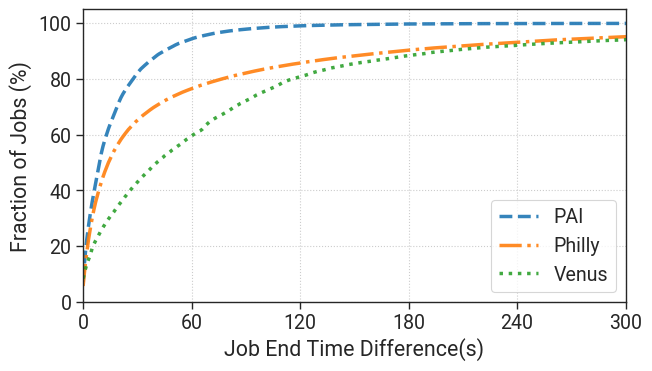

In [4]:
# CDFs of End Time Difference

for idx, df in enumerate(trace_dfs):
	if idx == 0:
		df.sort_values(by='real_end_time', inplace=True)
		df['end_time_diff'] = df['real_end_time'] - df['real_end_time'].shift(1)
		df['end_time_diff'] =  df['end_time_diff'].fillna(0)
	else:
		df['real_end_time'] = pd.to_datetime(df['real_end_time'])
		df.sort_values(by='real_end_time', inplace=True)
		df['end_time_diff'] = df['real_end_time'].diff().dt.total_seconds()
		df['end_time_diff'] =  df['end_time_diff'].fillna(0)

fig = plt.figure(figsize=(7, 3.8))

linestyles = ["--", "-.", ":", "--"]
y_at_60s = []
y_at_300s = []
for idx, trace_df in enumerate(trace_dfs):
	# Duration Ratio
	end_time_counter = trace_df.end_time_diff.value_counts()
	end_time_counter.sort_index(inplace=True)
	end_time_index = end_time_counter.index
	end_time_value = end_time_counter.values
	y_cdf = np.cumsum(end_time_value) / sum(end_time_value) * 100
	plt.plot(end_time_index, y_cdf, linestyles[idx], alpha=0.9, label=data_name[idx])

	y_at_60s.append(np.interp(60, end_time_index, y_cdf))
	y_at_300s.append(np.interp(300, end_time_index, y_cdf))
	

plt.xlim(0, 300)
plt.xlabel(f"Job End Time Difference(s)")
plt.ylabel(f"Fraction of Jobs (%)")
plt.xticks([0, 60, 120, 180, 240, 300])
plt.ylim(0, 105)
plt.legend(loc="lower right")
plt.grid(linestyle=":")

save = True
if save:
	fig.savefig(
		f"../figures/job_cdf_endTimeDiff.pdf", bbox_inches="tight", dpi=600,
	)
print(y_at_60s)
print(y_at_300s)

In [5]:
s = set()
for df in trace_dfs:
	print(df.gpu_num.unique())
	for g in df.gpu_num.unique():
		s.add(g)
print(sorted(s))

[1. 2. 8. 3. 4. 5. 6. 7.]
[  1   2   8   4  16  48  32 128  64  24  20  12]
[  1  32   4   8   2 128  16  24  14  80   6   5   3   7  56  48  40 120
  64 112  96 104  88 136 144  72 160 152]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 12, 14, 16, 20, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160]


In [5]:
ratios = []
for df in trace_dfs:
	tmp = df[df['gpu_num'] >= 8]
	ratios.append(round(len(tmp) / len(df) * 100, 2))
print(ratios)

[0.36, 5.6, 29.64]


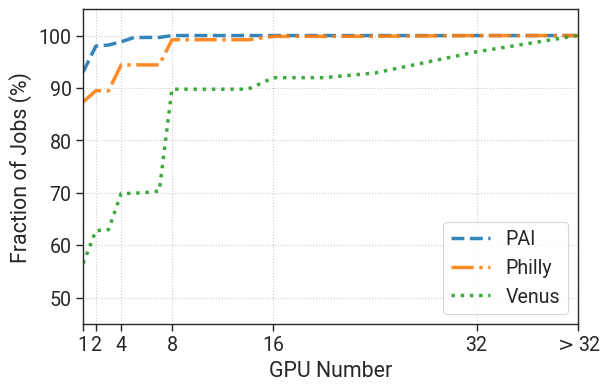

In [6]:
# CDFs of GPU Number & Duration Time

# fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 4))
fig, ax1 = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 3.8))

linestyles = ["--", "-.", ":", "--"]

for idx, trace_df in enumerate(trace_dfs):
	# GPU Ratio
	gpu_counter = trace_df.gpu_num.value_counts()
	gpu_counter.sort_index(inplace=True)
	
	gpu = [1, 2, 3, 4, 5, 6, 7, 8, 12, 14, 16, 20, 24, 32, 40] # 
	values = [0 for _ in range(len(gpu))]
	for k, v in gpu_counter.items():
		if k < gpu[-1]:
			values[gpu.index(k)] = v
		else:
			values[-1] += v
	gpu_cdf = np.cumsum(values) / sum(values) * 100

	# Duration Ratio
	duration_counter = trace_df.duration.value_counts()
	duration_counter.sort_index(inplace=True)
	duration_index = duration_counter.index
	duration_value = duration_counter.values
	y_cdf = np.cumsum(duration_value) / sum(duration_value) * 100

	ax1.plot(gpu, gpu_cdf, linestyles[idx], alpha=0.9, label=data_name[idx])

	# ax2.plot(duration_index, y_cdf, linestyles[idx], alpha=0.9, label=data_name[idx])

ax1.set_xlabel(f"GPU Number")
ax1.set_ylabel(f"Fraction of Jobs (%)")
xticks = [1, 2, 4, 8, 16, 32, 40]
ax1.set_xticks(xticks)
ax1.set_xticklabels([1, 2, 4, 8, 16, 32, "$>$32"])
ax1.set_xlim(1, 40)
ax1.set_ylim(45, 105)
ax1.legend(loc="lower right")
# ax1.text(0.45, -0.4, "(a)", transform=ax1.transAxes, size=14)
ax1.grid(linestyle=":")

# ax2.set_xlabel(f"Job Duration Time (s)")
# ax2.set_ylabel(f"Fraction of Jobs (%)")
# ax2.set_xscale("log")
# ax2.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
# ax2.set_ylim(0, 105)
# ax2.legend(loc="lower right")
# ax2.grid(linestyle=":")
# ax2.text(0.45, -0.4, "(b)", transform=ax2.transAxes, size=14)

save = False
if save:
	fig.savefig(
		f"../figures/job_cdf_jobtime.pdf", bbox_inches="tight", dpi=600,
	)

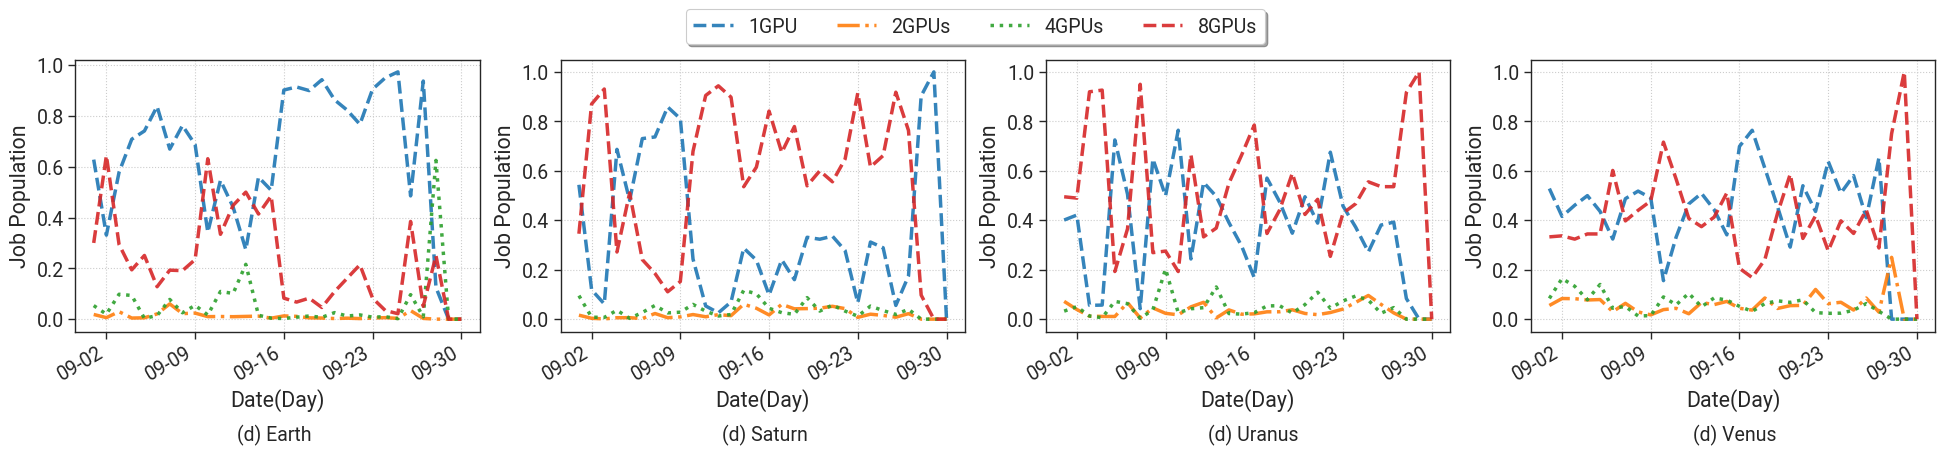

In [45]:
# draw Job Populations in Helios
clusters = ['Earth', 'Saturn', 'Uranus', 'Venus']
data_dir = '/data/nihaifeng/HeliosData/data/'
days = [i for i in range(1, 31)]
gpu_type = [1, 2, 4, 8]
linestyles = ["--", "-.", ":", "--"]
ax_number = ['a', 'b', 'c', 'd']

fig, ax = plt.subplots(1, 4, figsize=(24, 4))
axes = ax.flatten()

for idx, cluster in enumerate(clusters):
	ax = axes[idx]

	df = pd.read_csv(data_dir+cluster+'/cluster_log.csv')
	df['start_time'] = pd.to_datetime(df['start_time'])
	september_data = df[df['start_time'].dt.month == 9]

	all_map = []
	for day in days:
		day_data = september_data[september_data['start_time'].dt.day == day]
		gpu_count_map = day_data.gpu_num.value_counts()
		my_map = {gpu :0 for gpu in gpu_type}
		for k, v in gpu_count_map.items():
			k = k % 8
			k = k if k != 0 else 8
			if k in my_map:
				my_map[k] += v
		total = 0
		for k, v in my_map.items():
			total += v
		normalized_gpu_count_map = {k : v / total if total != 0 else 0 for k, v in my_map.items()}
		all_map.append(normalized_gpu_count_map)

	for idx, gpu in enumerate(gpu_type):
		y = [map.get(gpu, 0) for map in all_map]
		dates = pd.to_datetime([f'2020-09-{day:02d}' for day in days])
		ax.plot(dates, y, linestyles[idx], alpha=0.9)
	ax.set_xlabel("Date(Day)")
	# ax.set_xticks([1, 7, 14, 21, 28])
	ax.set_ylabel("Job Population")
	ax.grid(linestyle=":")
	ax.text(0.4, -0.4, f"({ax_number[idx]}) {cluster}", transform=ax.transAxes, size=14)
	
	ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
	ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
	ax.figure.autofmt_xdate() 

labels = ['1GPU', '2GPUs', '4GPUs', '8GPUs']
fig.legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4, fancybox=True,shadow=True,)
plt.subplots_adjust(wspace=0.2) 

save = True
if save:
	fig.savefig(f"../figures/job_population.pdf", bbox_inches="tight", dpi=600,)